In [360]:
#!pip freeze > requirements.txt

In [361]:
!pip install -r requirements.txt

In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

### Lettura del dataset

In [363]:
dataset = pd.read_csv('appointment_data.csv')

### Primo label encoder

In generale il Label Encoder codifica le etichette di destinazione con un valore compreso tra 0 e n_classi-1.


Questo è un primo label encoder che vado ad effettuare su tutto il dataset solo per poter andare a studiare la correlazione tra le features e poter andare a fare features selection in seguito, scartando le features considerate da me meno utili.

Come appena detto questo label encoder è usato UNICAMENTE per studiare la correlazione tra features.

In [364]:

label_encoder = LabelEncoder()

for i in dataset:
    dataset[i] = label_encoder.fit_transform(dataset[i])
    
dataset

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,0,9173,48073,0,45531,15,25,45,0,0,0,0,0,0
1,0,45698,51752,1,48964,13,62,24,0,0,0,0,0,0
2,1,21063,2092,0,2033,6,65,38,0,0,0,0,0,0
3,0,42931,21338,1,20373,0,41,43,0,0,0,0,0,0
4,0,32796,38998,1,36990,6,61,44,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88416,0,5199,35169,0,33413,7,63,77,0,1,1,0,0,1
88417,0,13259,15656,1,15003,21,31,43,0,0,0,0,0,0
88418,0,5284,80263,0,76004,26,38,1,0,0,0,0,0,0
88419,0,43945,21812,0,20818,0,18,44,1,0,0,0,0,0


### Heatmap:

Per poter andare a decidere quali features andare a prendere in considerazione e quali no, sono andato ad utilizzare una heatmap, in maniera tale da andare a studiare quella che è la correlazione tra le varie features.

Le features che ho scelto di andare a scartare sono:

1) **ScheduledDay** e l'**AppointmentDay**, in quanto ho deciso di andare a prendere in considerazione quella che è la "differenza tra le due"(Days_of_waiting--> spiegata sotto).

2) **Gender**, in quanto non ho visto alcuna correlazione significativa con nessuna features, anzi. L'unico accenno di correlazione "da notare", l'ho visto con  Alcoholism, ma non sono comunuque riuscito a notare alcuna relazione effettivamente significativa ai fini della mia analisi o comunque non ho trovato alcun punto di collegamento su cui estrarre informazione utile.

3) **Neighbourhood**, in quanto ha dei valori di correlazione insignificanti con tutte le restanti features e quindi ho deciso di non prenderla in considerazione per la mia analisi.

4) **PatientId** e **AppointmentID**: valgono le stesse considerazioni fatte ad esempio per **Neighbourhood**


Text(0.5, 1, 'Correlation between different features')

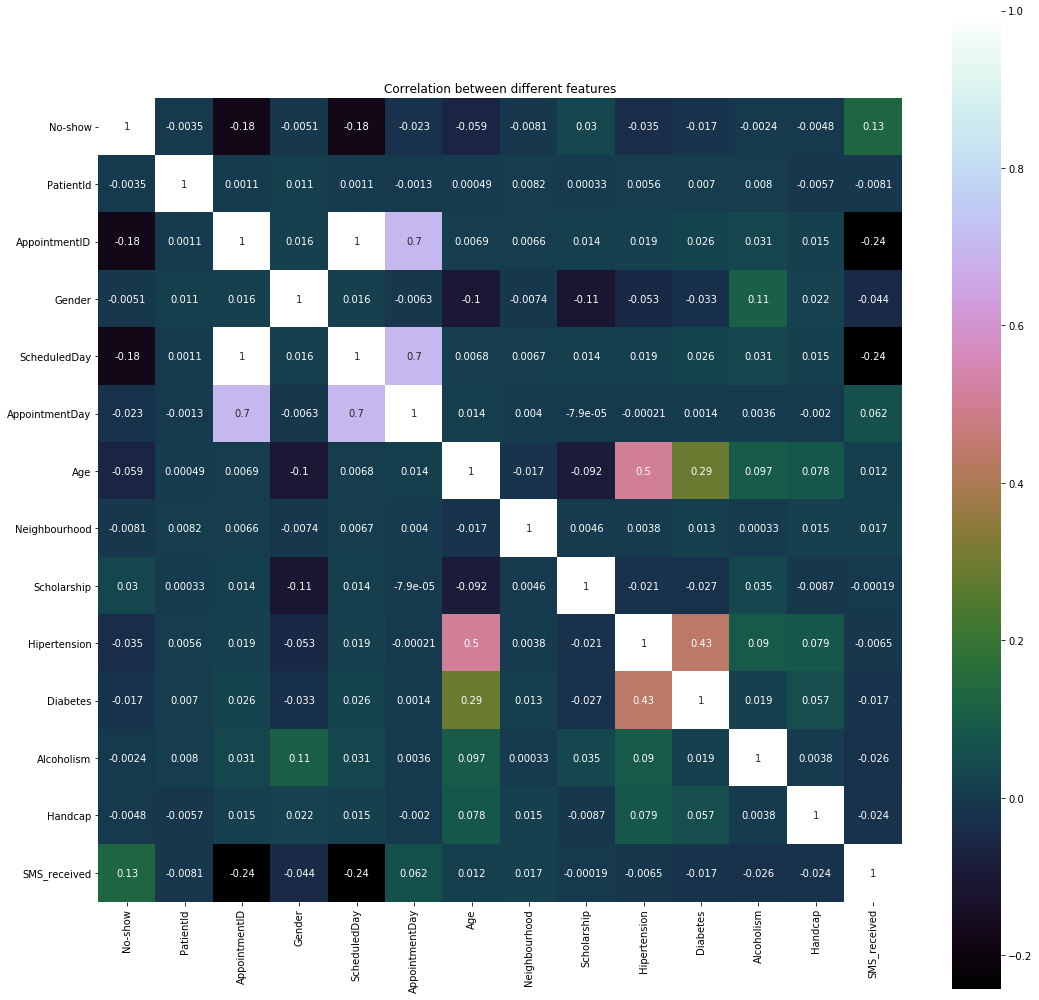

In [365]:
#heatmap per la selezione delle features     
correlation = dataset.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlation between different features')

## Creazione Features

### Age:

Divido i possibili valori di age presenti in quattro macro-classi

In [366]:
#divisione in classi età
def age_division(dataset):
    
    dataset= dataset.copy()

    age = np.asanyarray(dataset['Age'])
 
    for i in range(0, age.size):
        if 0 <= age[i] <= 20:
            age[i] = 0
        elif 21 <= age[i] <= 40:
            age[i] = 1
        elif 41 <= age[i] <= 90:
            age[i] = 2
        else:
            age[i] = 3
            
    dataset['Age'] = pd.DataFrame(age)
    
    return dataset

### Days_of_waiting:

Ho deciso di andare a valutare i giorni di attesa di differenza che ci sono tra lo ScheduledDay e l'AppointmentDay.

Sono andato ad effettuare un arrotondamento considerando i giorni dei mesi 30.

In [367]:
def days_of_waiting(dataset):
    
    dataset= dataset.copy()

    waiting_days= []

    for i in range(dataset.shape[0]):

        data_Scheduled, ora_Scheduled= dataset['ScheduledDay'].loc[i].split('T')
        data_Appointment, ora_Appointment= dataset['AppointmentDay'].loc[i].split('T')

        annoS, meseS, giornoS= data_Scheduled.split('-')
        annoA, meseA, giornoA= data_Appointment.split('-')

        months_difference= (int(meseA)-int(meseS))*30

        if(int(annoS)==int(annoA)):
            if(int(meseS)==int(meseA)):
                if(int(giornoS)==int(giornoA)):
                    waiting_days.append(0)
                else:
                    waiting_days.append(abs(int(giornoA)-int(giornoS)))
            else:
                waiting_days.append(abs(int(giornoA)+months_difference-int(giornoS)))
        else:
            years_difference= (int(annoA)-int(annoS))*365
            waiting_days.append(abs(int(giornoA)+months_difference+years_difference-int(giornoS)))                        

    dataset['days_of_waiting'] = waiting_days
    
    return dataset

In [368]:
def transf(dataset):
    
    dataset= dataset.copy()
    
    dataset= age_division(dataset)
    dataset= days_of_waiting(dataset)
    
    dataset = dataset.drop(columns=['AppointmentDay','AppointmentID','Gender','Neighbourhood','PatientId','ScheduledDay'])
    
    return dataset

In [369]:
train_csv = pd.read_csv('train.csv')

In [370]:
test_csv = pd.read_csv('test.csv')

In [371]:
train = transf(train_csv.copy())
test = transf(test_csv.copy())

#### In questo caso vado ad effettuare l'encoding ma senza andare ad utilizzare direttamente il label encoding perchè tanto ho due soli valori e quindi applico direttamente la funzione map

In [372]:
train['No-show']= train['No-show'].map({"Yes": 1, "No": 0})
test['No-show']= test['No-show'].map({"Yes": 1, "No": 0})

In [373]:
Y_train, Y_test = train['No-show'], test['No-show']
X_train, X_test = train.drop(columns=['No-show']), test.drop(columns=['No-show'])

In [374]:
tr = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=5)


#fit e prediction
tr.fit(X_train, Y_train)
pred = tr.predict(X_test)
print('Accuracy:',accuracy_score(Y_test, pred))

Accuracy: 0.8031099802092169
